In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from sklearn.metrics.pairwise import cosine_similarity
import pickle


In [3]:
# Load dataset
df = pd.read_csv("online_retail.csv", encoding='ISO-8859-1')  # Adjust filename if needed
df.head()

# Data Cleaning
df.dropna(subset=['CustomerID'], inplace=True)
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

# Create total price column
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])


In [4]:
# Set reference date as one day after last purchase
reference_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

# Group by CustomerID
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']


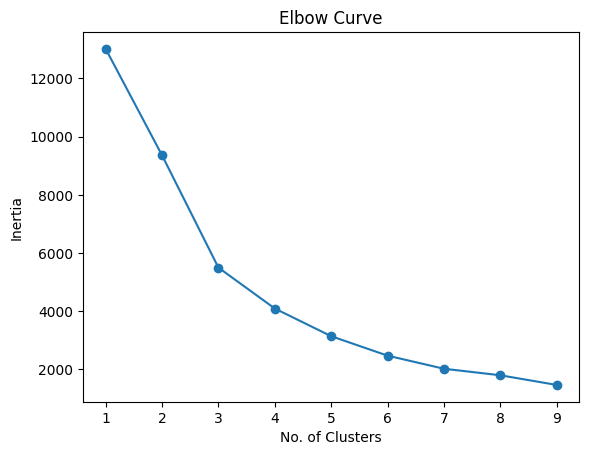

In [5]:
# Normalize
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

# Elbow Method
inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 10), inertia, marker='o')
plt.title('Elbow Curve')
plt.xlabel('No. of Clusters')
plt.ylabel('Inertia')
plt.show()

# Apply KMeans
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Save Model
with open('rfm_kmeans_model.pkl', 'wb') as file:
    pickle.dump(kmeans, file)

# Save Scaler
with open('rfm_scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)


In [6]:
# Create Product-Customer Matrix
pivot_df = df.pivot_table(index='Description', columns='CustomerID', values='Quantity', fill_value=0)

# Compute Cosine Similarity
similarity_matrix = cosine_similarity(pivot_df)
similarity_df = pd.DataFrame(similarity_matrix, index=pivot_df.index, columns=pivot_df.index)

# Save for Streamlit use
similarity_df.to_pickle("product_similarity.pkl")

# Recommend Function
def recommend_products(product_name, top_n=5):
    if product_name not in similarity_df.index:
        return "Product not found."
    similar_scores = similarity_df[product_name].sort_values(ascending=False)[1:top_n+1]
    return similar_scores
